<a href="https://colab.research.google.com/github/Annaother/pymdp/blob/master/Hider_Interactive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Import relevant packages

import pkg_resources #to check if certain packages are installed

import os
import sys
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy


#check if pymd package is installed in the env
if 'pymdp' in {pkg.key for pkg in pkg_resources.working_set}:
    print("pymdp package is installed")
else:
    print("pymdp package is not installed")
    !pip install git+https://github.com/infer-actively/pymdp.git 
 

from pymdp import utils 
from pymdp.agent import Agent
from pymdp.maths import softmax
from pymdp.utils import plot_likelihood


pymdp package is not installed
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/infer-actively/pymdp.git to /tmp/pip-req-build-co9yce9q
  Running command git clone --filter=blob:none --quiet https://github.com/infer-actively/pymdp.git /tmp/pip-req-build-co9yce9q
  Resolved https://github.com/infer-actively/pymdp.git to commit 2d2152c79d4b28c8efc4a7a77012a5d1c146ec32
  Preparing metadata (setup.py) ... done


In [ ]:
## Specify dimensionalities of hidden state factors, control factors and observation modalities

context_names = ['Left Hand', 'Right Hand'] ## 2 contexts controlled by other agent: seeker chose penny left or right
choice_names = ['Hide left', 'Hide right']

""" Define `num_states` and `num_factors` below """
num_states = [len(context_names), len(choice_names)]
num_factors = len(num_states)

context_action_names = ['Do-nothing']
choice_action_names = ['Hide penny left', 'Hide penny right'] ## 2 actions: choose to hide penny left and hide penny right

""" Define `num_controls` below """
num_controls = [len(context_action_names), len(choice_action_names)]

reward_obs_names = ['Loss', 'Reward']
choice_obs_names = ['Left Hand', 'Right Hand']

""" Define `num_obs` and `num_modalities` below """
num_obs = [len(reward_obs_names), len(choice_obs_names)]
num_modalities = len(num_obs)

The *0-ToM hider* is an active inference agent that learns to predict its reward outcomes and infer the other player's choices in a matching pennies paradigm
The agent architecture is based on the agent class introduced by Conor Heins, Alexander Tschantz, Daphne Demekas, Brennan Klein

## Hidden states

Context states (other-states that need to be inferred)
    1. Seeker chose to seek penny in left hand
    2. Hider chose to seek penny in right hand 


Choice states (self-states that are directly accessible)
    1. Hide in left hand 
    2. Hide in right hand 


Observation modalities
    1. Self-choices (directly accessible)
    2. Reward outcomes (noisy) 


## Likelihood Matrix A

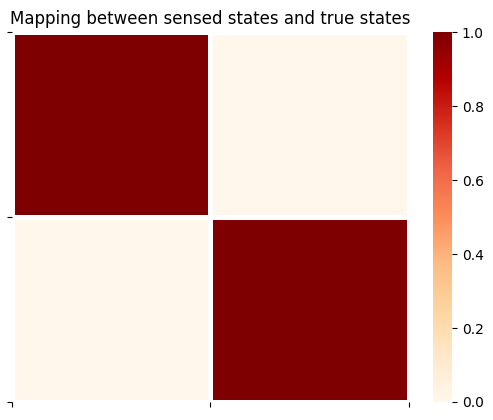

In [ ]:
## Likelihood matrix A of observations O given hidden states S

""" Generate the A array """
A = utils.obj_array(num_modalities)

#### 1. Likelihood of proprioceptive/interoceptive observations (left choice or right choice) given beliefs about self-choice (left or right) and where the penny is hidden (context states left or right)
A_choice = np.zeros((len(choice_obs_names), len(choice_names), len(context_names)))


    #### 1.1. Likelihood of observing left choice given beliefs left choice and sought left
    #### 1.2. Likelihood of observing left choice given beliefs left choice and sought right
    #### 1.3. Likelihood of observing left choice given beliefs right choice and sought left
    #### 1.4. Likelihood of observing left choice given beliefs right choice and sought right

    #### 1.5. Likelihood of observing right choice given beliefs left choice and sought left
    #### 1.6. Likelihood of observing right choice given beliefs left choice and sought right
    #### 1.7. Likelihood of observing left choice given beliefs right choice and sought left
    #### 1.8. Likelihood of observing right choice given beliefs right choice and sought right


for choice_id in range(len(choice_names)):

  A_choice[choice_id, :, choice_id] = 1.0 ## self-choices are fully transparant 

A[0] = A_choice

plot_likelihood(A[0][:,0,:], "Mapping between sensed states and true states") ##plot likelihood mapping between choice observation and inferred choice state


In [ ]:
#### 2. Likelihood of reward observations (win or loose) given beliefs about self-choices (left or right) and where the penny is hidden (context states left or right)

""" Initialize matrix storing likelihood mapping reward opbservations to hidden states"""
from difflib import context_diff


A_reward = np.zeros((len(reward_obs_names), len(context_names), len(choice_names)))

## Likelihood mappings for each reward observation
for choice_id, choice_name in enumerate(choice_names):
    
    for context_id, context_name in enumerate(context_names):
      
      if choice_name == 'Hide left':
        
        if context_name == 'Left Hand': 
          A_reward[1,context_id, choice_id] = 0 #### 1.1. Likelihood of observing a win given left choice and hid left
      
        elif context_name == 'Right Hand':
          A_reward[1, context_id, choice_id] = 1 #### 1.2. Likelihood of observing a win given left choice and hid right

      elif choice_name == 'Hide right':
         
          if context_name == 'Left Hand':
            A_reward[1, context_id,choice_id] = 1 #### 1.3. Likelihood of observing a win given right choice and hid left
          
          elif context_name == 'Right Hand':
            A_reward[1, context_id, choice_id] =  0 #### 1.4. Likelihood of Sobserving a win given right choice and hid right

      A_reward[0,context_id,choice_id] = 1 - A_reward[1, context_id, choice_id] #### Likelihood of observing a loss is just 1- observing a win for each case

print(choice_names)

print(context_names)


## Assign reward and choice-likelihoods to datastructure for A
A[1] = A_reward

print(A_reward)


['Hide left', 'Hide right']
['Left Hand', 'Right Hand']
[[[1. 0.]
  [0. 1.]]

 [[0. 1.]
  [1. 0.]]]


In [ ]:
#function to normalize multidimensional arr
A_reward = utils.norm_dist(A_reward)

print(A_reward)


[[[1. 0.]
  [0. 1.]]

 [[0. 1.]
  [1. 0.]]]


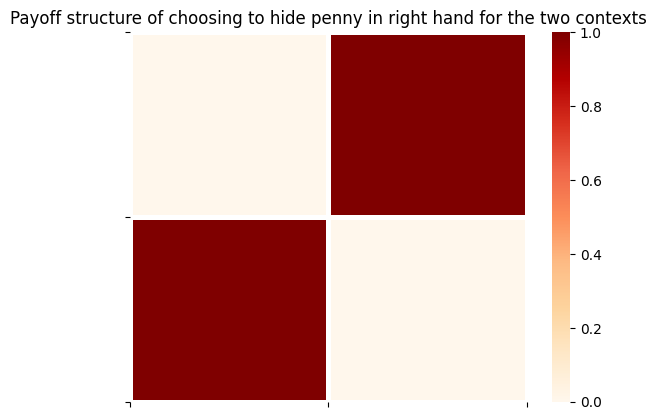

In [ ]:
plot_likelihood(A[1][:,:,1], 'Payoff structure of choosing to hide penny in right hand for the two contexts')

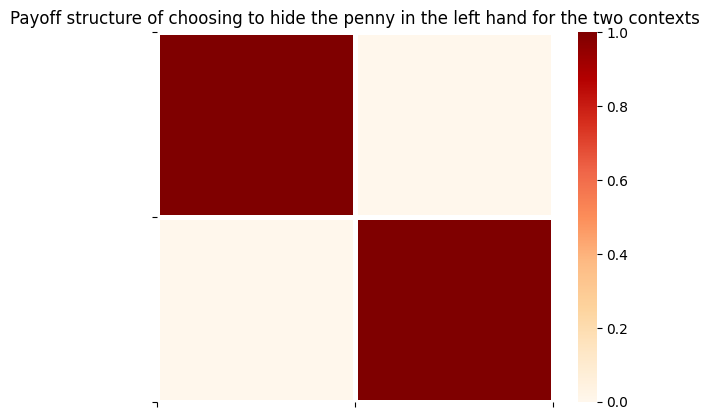

In [ ]:
plot_likelihood(A[1][:,:,0], 'Payoff structure of choosing to hide the penny in the left hand for the two contexts') 

## State transitions B

In [ ]:
## State transitions between hidden states B

""" Initialize B-array"""
B = utils.obj_array(num_factors)

""" Fill in transition probabilities for the context (Hider actions) which are uncontrollable""" 
B_context = np.zeros( (len(context_names), len(context_names), len(context_action_names)) )
B_context[:,:,0] = np.eye(len(context_names))
B[0] = B_context

""" Fill in transition probabilities for choice state factor, which are controllable"""
B_choice = np.zeros( (len(choice_names), len(choice_names), len(choice_action_names)) )

for choice_i in range(len(choice_names)):
  
  B_choice[choice_i, :, choice_i] = 1.0 #action x leads to to choice state x, independently of previous state

B[1] = B_choice
B[1]= utils.norm_dist(B[1])

print(B)


[array([[[1.],
         [0.]],

        [[0.],
         [1.]]]) array([[[1., 0.],
                         [1., 0.]],

                        [[0., 1.],
                         [0., 1.]]])]


In [ ]:
## Prior preferences C for outcomes 

""" Initialize C based on the number of observation modalities"""
C = utils.obj_array_zeros(num_obs)
C_reward = np.zeros(len(reward_obs_names))

### 1. Reward outcomes (noisy): preference (win)> preference (loose)
C_reward[0] = -4.0 ## strong aversion to loss observation
C_reward[1] = 2.0  ## slight preference for win

### 2. Self-choices (directly accessible): no prior preferences, so C[2] remains flat
C[0] = C_reward


In [ ]:
## Starting state D: random starting state

""" Initialize D based on hidden state factors: choice and context"""
D = utils.obj_array(num_factors)

## Starting-point context hidden state: no beliefs about context or choices or contexts
D_context = np.array([0.5,0.5]) #random starting context-state
D[0] = D_context

## Starting point choice hidden state
D_choice = np.zeros(len(choice_names)) # random starting choice-state
D_choice = np.array([0.5,0.5])

D[1] = D_choice

In [ ]:
## Prior preference over actions E: no prior preference
E = utils.obj_array_zeros(num_controls)
E = np.array([0.5,0.5]) 

# Additional parameters

Active inference allows for the specificafion of parameters alpha and gamma that control randomness in action selection and prior precision, respectively. 

For alpha > 16...., for alpha < 16 ...
For gamma > 16...., for gamma < 16...

In [ ]:
alpha = 16
gamma = 16  #default value = 16

In [ ]:
# Use agent class to construct active inference agent 
OToM_agent = Agent(A,B,C,D,E,alpha, gamma)

In [35]:
!git 

!git config –global user.email “nvrmindny7@gmail.com”
!git config –global user.name “Annaother”

fatal: not in a git directory
fatal: not in a git directory
